# Data Science Workshop Project
**Team:** Elad Bilman, Oz Hezkia, Eva Hallermeier, Tzach Cohen

**Problem:** The predictors of in-hospital mortality for admitted patients remain poorly characterized.

**Goal of the project**: We aimed to develop and validate a prediction model for all-cause in-hospital mortality among admitted patients.

## 1- Dataset: Patient Survival Prediction

We choose a dataset from Kaggle  https://www.kaggle.com/datasets/mitishaagarwal/patient

The dataset is a collection of medical data of admitted patients at hospital.

#### Import modules and librairies

In [97]:
%matplotlib inline

In [98]:
#data processing
import pandas as pd
import numpy as np

#Machine learning library
import sklearn
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

#Analyze model
import shap
from sklearn.metrics import confusion_matrix

#visualization
import matplotlib.pylab as plt
from matplotlib.ticker import MultipleLocator
import seaborn as sns

from DataprocessingMethods import *
from Model.FinalModel import FinalModel
from Model.ModelModule import DSWorkshopModel
from MissingValuesVisualization import *

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [99]:
#load dataset
first_dest_file_path = "dataset/dataset_part1.csv"
second_dest_file_path = "dataset/dataset_part2.csv"
df1 = pd.read_csv(first_dest_file_path)
df2 = pd.read_csv(second_dest_file_path)
df= pd.concat([df1, df2])
df.head() #beginning of the dataset

,encounter_id,patient_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,icu_admit_source,...,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem,Unnamed: 83,hospital_death
0,66154,25312,118,68.0,22.73,0,Caucasian,M,180.3,Floor,...,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular,NaN,0
1,114252,59342,81,77.0,27.42,0,Caucasian,F,160.0,Floor,...,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory,NaN,0
2,119783,50777,118,25.0,31.95,0,Caucasian,F,172.7,Accident & Emergency,...,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic,NaN,0
3,79267,46918,118,81.0,22.64,1,Caucasian,F,165.1,Operating Room / Recovery,...,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular,NaN,0
4,92056,34377,33,19.0,NaN,0,Caucasian,M,188.0,Accident & Emergency,...,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma,NaN,0


The dataset is originally composed of 85 columns (features) and we have 91 713 patients. We can already see that we have an entire empty column that we will remove.

## 2- Analyze dataset

We have different types of feature: numerical, categorical and binary. Some of the features are data about the medical measures of the patient and some are description of hospital unit and cares he received.
In addition, we wrote a complete file which explains all medical features.

In [100]:
categorial_features = ["hospital_id", "ethnicity", "gender", "icu_admit_source", 
                       "apache_3j_bodysystem", "apache_2_bodysystem", "icu_stay_type", "icu_type"]

numerical_features = ["age", "bmi","height", "weight", 
                      "pre_icu_los_days", "gcs_eyes_apache","apache_2_diagnosis",
                      "gcs_motor_apache", "gcs_verbal_apache", "heart_rate_apache",
                     "map_apache", "resprate_apache", "temp_apache", "d1_diasbp_max",
                      "d1_diasbp_min","d1_diasbp_noninvasive_max", "d1_diasbp_noninvasive_min",
                      "d1_heartrate_max", "d1_heartrate_min", "d1_mbp_max", "d1_mbp_min", 
                      "d1_mbp_noninvasive_max", "d1_mbp_noninvasive_min", "d1_resprate_max", 
                      "d1_resprate_min","d1_spo2_max", "d1_spo2_min", "d1_sysbp_max", "d1_sysbp_min",
                      "d1_sysbp_noninvasive_max", "d1_sysbp_noninvasive_min", "d1_temp_max", 
                      "d1_temp_min","h1_diasbp_max", "h1_diasbp_min", "h1_diasbp_noninvasive_max", 
                      "h1_diasbp_noninvasive_min","h1_heartrate_max", "h1_heartrate_min", 
                      "h1_mbp_max", "h1_mbp_min","h1_mbp_noninvasive_max", "h1_mbp_noninvasive_min",
                      "h1_resprate_max", "h1_resprate_min","h1_spo2_max", "h1_spo2_min", 
                      "h1_sysbp_max", "h1_sysbp_min","h1_sysbp_noninvasive_max", 
                      "h1_sysbp_noninvasive_min", "d1_glucose_max", "d1_glucose_min",
                      "d1_potassium_max", "d1_potassium_min", "apache_4a_hospital_death_prob", 
                      "apache_4a_icu_death_prob","apache_3j_diagnosis"]


binary_features = ["arf_apache", "gcs_unable_apache", "intubated_apache", 
                   "ventilated_apache", "elective_surgery", "apache_post_operative",
                   "aids", "cirrhosis", "diabetes_mellitus", "hepatic_failure", "immunosuppression",
                   "leukemia", "lymphoma", "solid_tumor_with_metastasis"]

## 3- Data science prediction problem

**Prediction problem**: binary classification : hospital death which 1 means hospital death and 0 means go out alive from hospital.

([<matplotlib.patches.Wedge at 0x1b3341b0190>,
 [Text(-1.0598172020063896, 0.294597179774939, '0'),
  Text(1.0598172295885635, -0.2945970805476902, '1')],
 [Text(-0.5780821101853033, 0.16068937078633036, '91.4%'),
  Text(0.5780821252301255, -0.16068931666237643, '8.6%')])

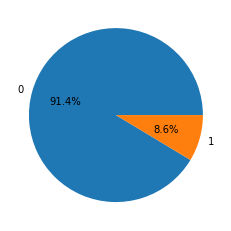

In [101]:
class_prediction = "hospital_death"
unique_labels = np.unique(df[class_prediction])
plt.pie(np.array([len(df[df[class_prediction]==label]) for label in unique_labels ]), 
        labels = list(unique_labels), autopct='%1.1f%%')

As you can see, the contrast between the distribution of the two label classes is exceptionally large, with the label '1' being far less common.

Due to that, it will be a challenge for the model to predict the label '1', which represents cases that ended with patients' death.

Another challenge we face is keeping the model from being biased, since most of the data is labeled with '0' which will cause the model to easily predict this label, but not the other.
So we need to deal with an original unbalanced dataset.

## 4- Sanitizing and organize dataset: missing data

### Missing values

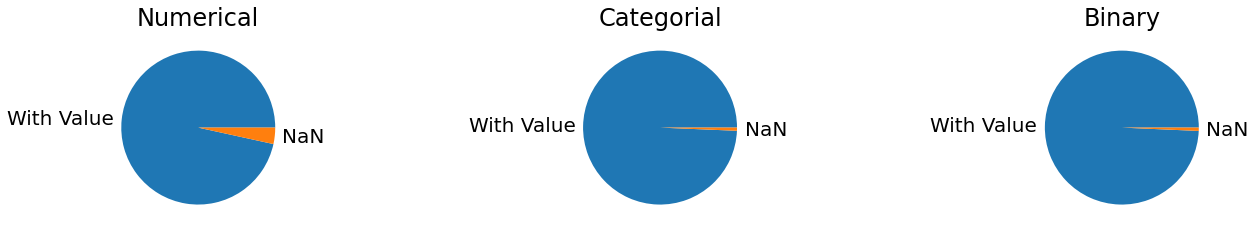

In [102]:
visualizeMissingValues(df)

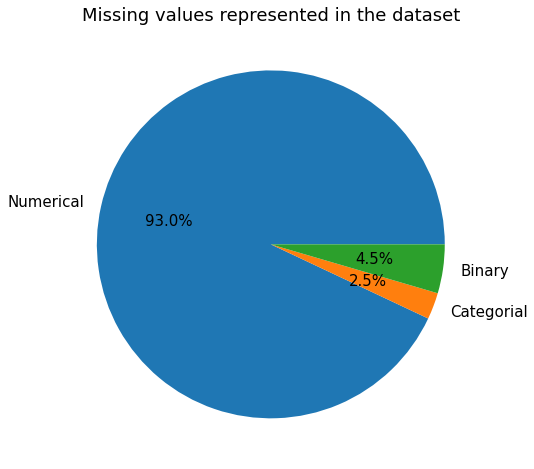

In [103]:
missingValuesDistribution(df)

Most of missing values are numerical.

**Deal with missing values:**
- For categorical values: we will make one hot encoding so we will do not need to deal with missing values: cells with no categories will just not have positive value in the new columns of one encoding
- For numerical values: we will fill with mean
- For binary values: we will fill missing values with 0 : most of binary values tell if appear a given problem or a specific care : we will asume that if its not written that it hasn t happen.

## 5- Data visualization

**5.1 Data distribution**

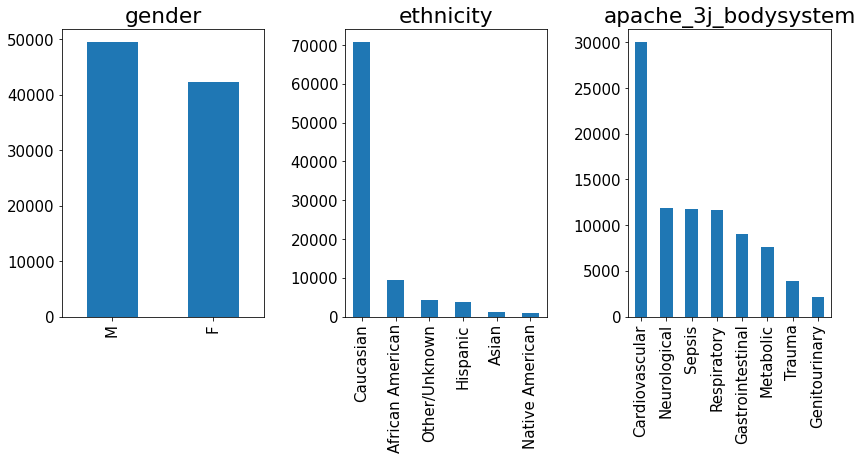

In [104]:
# Histograms of interesting categorical feature: gender, ethnicity and admission diagnoosis (type of health problem)

columns =  ["gender", "ethnicity","apache_3j_bodysystem"]
fig, axes = plt.subplots(1,3,figsize=(12,5))

n=len(columns)
num_rows = 1
max_bars = 8

for i,variable in enumerate(columns):
    u=min(df[variable].nunique(),max_bars)
    vc = df[variable].value_counts()[:u]
    plt.rcParams.update({'font.size': 18})
    vc.plot(kind='bar',ax=axes[i],title=variable)
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.99, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

**5.2 Influence of the age of the patient on hospital death**

We know that older patient are and bigger the risk of death is: we can see it clearly on this graph. Number of deaths is bigger for older patients. We will also see in model execution that age is an important feature.

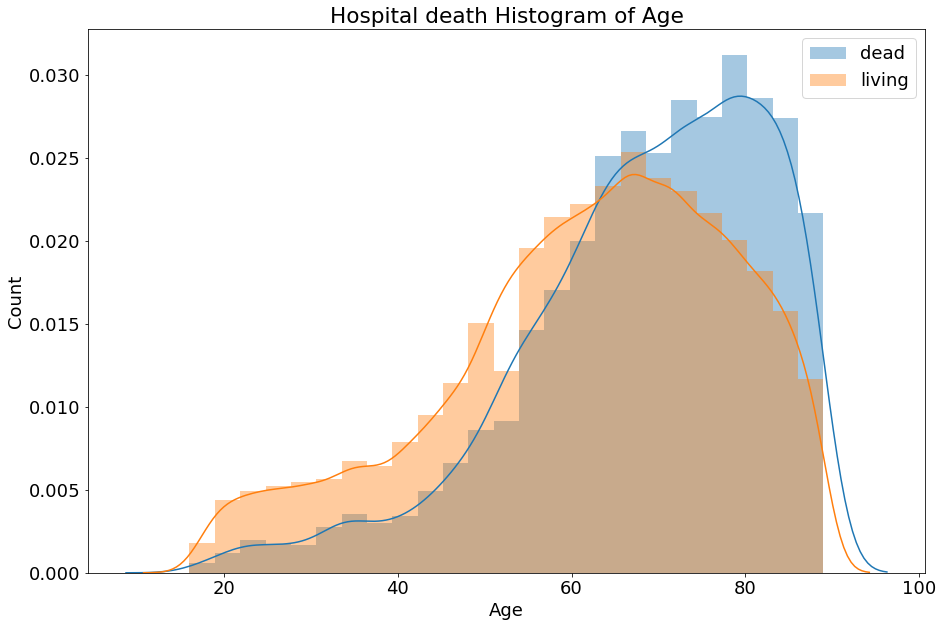

In [105]:
dead_patient = df[df["hospital_death"] == 1]
living_patient = df[df["hospital_death"] == 0]

fig,ax=plt.subplots(figsize=(15,10))

#create two histograms
sns.distplot(dead_patient.age, bins = 25, kde = True, label = "dead",ax=ax)
sns.distplot(living_patient.age, bins = 25, kde = True, label = "living",ax=ax)

plt.title('Hospital death Histogram of Age')
plt.xlabel('Age')
plt.ylabel('Count')
plt.legend(loc="upper right")

In [106]:
df = getBasicDataset()
#prepare data
x_data = df.drop('hospital_death', axis=1)
true_values = df.hospital_death
x_train, x_test, y_train, y_test = train_test_split(x_data, true_values, test_size=0.2, stratify=true_values, shuffle=True)
x_train = fill_missing_num_values_with_mean(x_train)
x_train = fill_missing_values_binary(x_train)
x_test = fill_test_missing_num_values_with_mean(x_test,x_train)
x_test = fill_test_missing_values_binary(x_test, x_train)

all_data = pd.concat([x_train, x_test], axis=0)

## 6- Running naive model for baseline,  results and performance analysis (SHAP)

We runned few basic models: random forest, extra tree and xgboost and we decided to keep xgboost and try to improve it

In [107]:
#init model
model = DSWorkshopModel(df) 
model.set_split(x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)

#train mondel
model.train()

#test model
models_predictions, pred_results = model.test()

#results
print(pred_results)

          Method  Precision Score  Recall Score  F1 Score  \
0  XGBClassifier         0.662095      0.335439  0.445283   

   Unbalanced Accuracy Score  Balanced Accuracy Score  \
0                   0.927874                 0.659635   

   Positive Accuracy Score  Negative Accuracy Score Time Needed for Training  
0                  0.33544                  0.98383                   46.01s  


Because we have an unbalanced model we will use balanced accuracy and recall as metrics and we will use XGBoost classifier and will try to improve it.

**Result of the basic model as baseline:**
- Recall around (positive accuracy) 33% so many false negative
- Precision around  67%
- Global Accuracy 93%
- Balanced accuracy around 65%
- Negative accuracy around 98 % 

Because we have only around 10 % of death case it means that if we have 90 % accuracy it means that we probably always give 0 as prediction let s verify it.

In [108]:
def conf_matrix(cf_matrix):
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cf_matrix.flatten()]

    group_percentages = ["{0:.2%}".format(value) for value in
                         cf_matrix.flatten()/np.sum(cf_matrix)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]

    labels = np.asarray(labels).reshape(2,2)

    ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

    ax.set_title('Confusion Matrix\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])

    ## Display the visualization of the Confusion Matrix.
    plt.show()

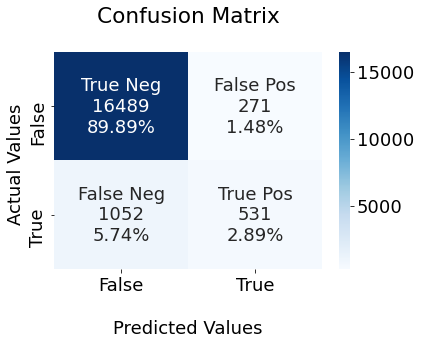

In [109]:
cf_matrix = confusion_matrix(y_test.to_numpy(), models_predictions[-1])
conf_matrix(cf_matrix)

As predicted the biggest problem is that we have too much false negative so our goal will be to reduce it.
We will prefer to predict death in order that a patient in danger will receive more attention and intensive care which maybe can save him.

### Analyze performance of the model
#### Precision recall curve: 
Precision-Recall curves should be used when there is a moderate to large class imbalance.

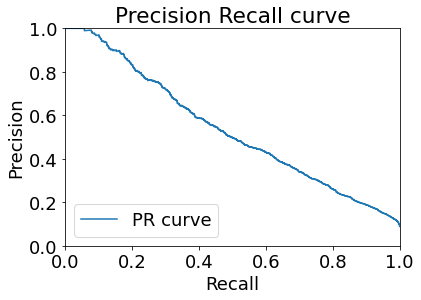

In [110]:
y_true = y_test
xgb = model.get_models()[0] #xgboost
predicted_probs = xgb.predict_proba(x_test)
y_score = predicted_probs[:,1]

def plotPR(precision, recall):
    plt.figure()
    plt.plot(recall, precision, label='PR curve')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision Recall curve')
    plt.legend(loc='lower left')
    plt.show()
    
precision, recall, thresholds = sklearn.metrics.precision_recall_curve(y_true, y_score, pos_label=1)
plotPR(precision, recall)

#### ROC curve
ROC curves should be used when there are roughly equal numbers of observations for each class which is not our case.

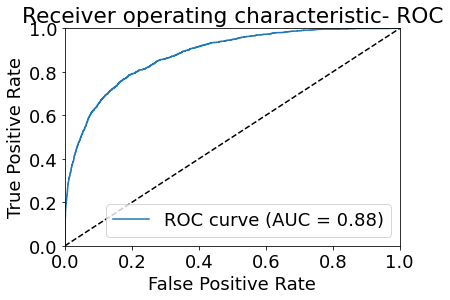

In [111]:
def plotRoc(fpr, tpr, auc):
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic- ROC')
    plt.legend(loc="lower right")
    plt.show()

auc = sklearn.metrics.roc_auc_score(y_true, y_score)
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_true, y_score)
plotRoc(fpr, tpr, auc)

### SHAP

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


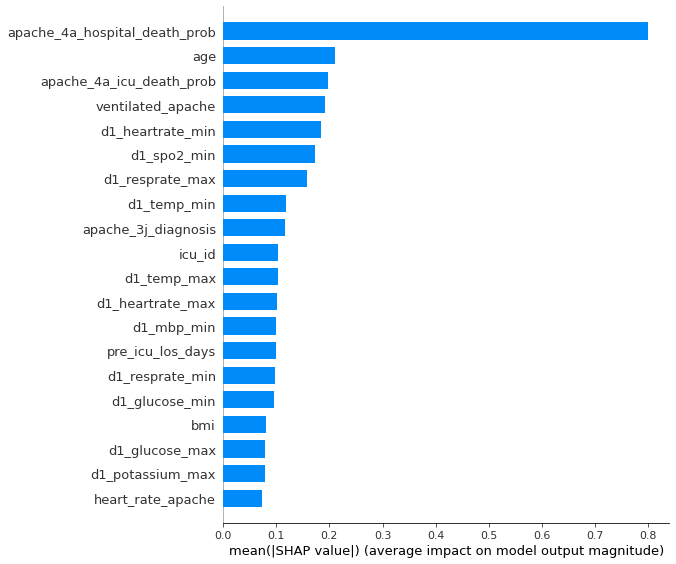

In [112]:
shap.initjs()
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(all_data)

#feature importance analysis
shap.summary_plot(shap_values, all_data, plot_type="bar")

We can see here clearly here which feature have the biggest influence on the prediction of the model.

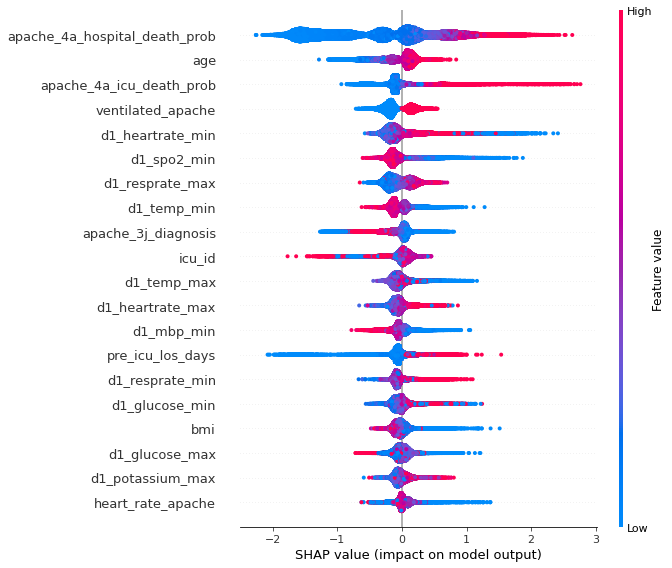

In [113]:
shap.summary_plot(shap_values, all_data)

## 7- Improvement of the naive model

### 7.1 Oversampling: make training set more balanced

In [114]:
df = getBasicDataset()

#prepare data
x_data = df.drop('hospital_death', axis=1)
true_values = df.hospital_death
x_train, x_test, y_train, y_test = train_test_split(x_data, true_values, test_size=0.2, stratify=true_values, shuffle=True)
x_train = fill_missing_num_values_with_mean(x_train)
x_train = fill_missing_values_binary(x_train)
x_test = fill_test_missing_num_values_with_mean(x_test,x_train)
x_test = fill_test_missing_values_binary(x_test, x_train)

oversample = RandomOverSampler(sampling_strategy='minority')
x_np = x_train.to_numpy()
y_np = y_train.to_numpy()
x_np, y_np = oversample.fit_resample(x_np, y_np)
# Convert back to pandas
x_train = pd.DataFrame(x_np, columns=x_train.columns)
y_train = pd.Series(y_np, name=y_train.name)


model = FinalModel(df)
model.set_split(x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)

#train mondel
model.train()

#test model
models_predictions, pred_results = model.test()

#results
print(pred_results)

          Method  Precision Score  Recall Score  F1 Score  \
0  XGBClassifier           0.2154       0.83765   0.34268   

   Unbalanced Accuracy Score  Balanced Accuracy Score  \
0                   0.722673                 0.774732   

   Positive Accuracy Score  Negative Accuracy Score Time Needed for Training  
0                  0.83765                  0.71181                  102.91s  


**Result of the basic model as baseline:**
- Recall around (positive accuracy) 81% and was 33% in the basic model!
- Balanced accuracy around 77 % and was around 65% in the basic model!
- Negative accuracy decrease a bit


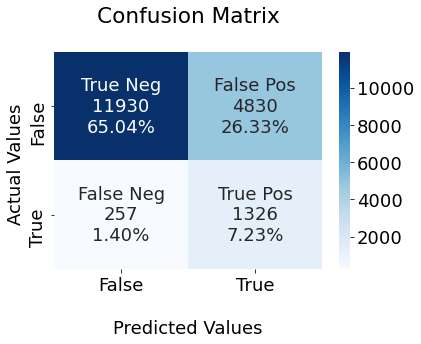

In [115]:
cf_matrix = confusion_matrix(y_test.to_numpy(), models_predictions[-1])
conf_matrix(cf_matrix)

We can say now that we now predict better death cases which was our goal.

## Conclusion

We built a model which predict death case for admitted patient at hospital. Our model is sensitive and can predict death even if the patient will probably finish alive but it is preferable this way because we don t want to miss patient that can be not treated as they need in order to stay alive.